# Using "method chains" to create more readable code

```{admonition} Suggested material
:class: tip

This page is optional but suggested. It shows you _way_ to write code. But this is useful because (A) it's often easier to write and read and (B) I will use it in  class often.
```

This page is about "chaining," which is a technique I use when writing python code, to take advantage of this fact about python:
```py
( 
    # anything between these parentheses
    # is interpreted as one line of code
    # so that long lines of code can be visually broken up
    # and chunks of code (doing a set of tasks) can be grouped
)
```

Code chains 
- help us write more **readable** code - the "code and the flow of execution are from top to bottom, and the function parameters are always near the function itself, unlike with heavily nested function calls", which are common in "normal" python scripts ([source: a core `pandas` dev](https://tomaugspurger.github.io/method-chaining)) 
- "emphasize a correctly \[and sequentially\] structured interactive approach to working with data, where each operation is a 'next step' after the last." ([source](https://www.kaggle.com/residentmario/method-chaining-reference))
- lessen the need to create and mentally track temporary variables
- are easy to debug: comment out operations that are failing until you fix them 
- you can have comments _within_ the chains (like the example above!)
- only temporarily modify the object, unless you name the resulting object (like `df = ( df <stuff> ... )`)


```{admonition} I think it's easiest to learn about chains via example.
:class: note

The material chains on this page is within the "v1.+" tabs below.
```

---

<p style="font-size:2.25em;"> Or, An analysis of the impact of Game of Thrones  </p>

This analysis will show off slicing data, computing statistics by groups, and some plotting.

I didn't find an off the shelf data set to run our seminal analysis in [Chapter 2](../02/10_Golden_2), but I found another option.

**Let's explore if Game of Thrones changed how babies are named!**[^inspo]

[^inspo]:  [Analysis by dhanushkishore](https://www.kaggle.com/dhanushkishore/) is the inspiration for our GoT analysis. I can't find their work anymore, but a similar (identical?) analysis is [here](https://www.kaggle.com/mkariithi/impact-of-game-of-thrones-on-us-baby-names). 

### Step 1: Download the data

In this example, we use a [data.world](data.world)'s function to download their data. 

In [1]:
#TO USE datadotworld PACKAGE:
#1. create account at data.world
#2. in terminal/powershell: pip install datadotworld
#
#   IF THIS DOESN'T WORK BC YOU GET AN ERROR ABOUT "CCHARDET", RUN:
#    conda install -c conda-forge cchardet
#   THEN RERUN: pip install datadotworld[pandas] 
#
#3. in terminal/powershell: dw configure          
#3a. copy in API token from data.world (get from settings > advanced)

import datadotworld as dw # to download data from data.world
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

baby_names = dw.load_dataset('nkrishnaswami/us-ssa-baby-names-national',auto_update=True)
baby_names = baby_names.dataframes['names_ranks_counts']

### Step 2: EDA 

Just because this code is skipping EDA doesn't mean you should! [Follow the best practices!](02e_eda_golden) In fact, I did do EDA on the dataset, which I why I know to combine boy/girl names below.

### Step 3: Analysis using Chains

The general plan is to plot the number of kids each year with GoT inspired names. So the general plan is:

1. save a slice of the dataset with the names we want 
2. sometimes a name is used by boys and girls in the same year, so combine the counts so that we have one observation per name per year (I learned this from EDA!!!)
3. save the dataset and then call a plot function

````{tabbed} v0.1 Without chains

On one hand, this is only "4" lines of code. On the other hand, this is as readable as I could make it!

```py
# STEP 1: restrict by name and only keep years after 2000

somenames = baby_names.loc[( # formating inside this () is just to make it clearer to a reader
    ( # condition 1: one of these names, | means "or"
        (baby_names['name'] == "Sansa") | (baby_names['name'] == "Daenerys") | 
        (baby_names['name'] == "Brienne") | (baby_names['name'] == "Cersei") |
        (baby_names['name'] == "Tyrion") 
    ) # end condition 1
    & # & means "and"
    ( # condition 2: these years
        baby_names['year'] >= 2000) # end condition 2
    )]

# STEP 2: if a name is used by F and M in a given year, combine the count variable
    # Q: why is there a "reset_index"? 
    # A: groupby automatically turns the groups (here name and year) into the index
    #    reset_index makes the index simple integers 0, 1, 2 and also
    #    turns the the grouping variables back into normal columns
    # A2: instead of reset_index, you can include `as_index=False` inside groupby!
    #     (I just learned that myself!)
somenames_agg = somenames.groupby(['name','year'])['count'].sum().reset_index().sort_values(['name','year'])

# STEP 3: plot
sns.lineplot(data=somenames_agg, hue='name',x='year',y='count')
plt.axvline(2011, 0,160,color='red') # add a line for when the show debuted
```

````


```` {tabbed} v0.2 No chains but better
 
```{tip}
`query` > `loc`
```

```py
# use query to filter, and the rest is the same

somenames = baby_names.query('name in ["Sansa","Daenerys","Brienne","Cersei","Tyrion"] & \
         year >= 2000') # this is one string with ' as the string start/end symbol. Inside, I can use 
                        # normal quote marks for strings. Also, I can break it into multiple lines with \
somenames_agg = somenames.groupby(['name','year'])['count'].sum().reset_index().sort_values(['name','year'])
sns.lineplot(data=somenames_agg, hue='name',x='year',y='count')
plt.axvline(2011, 0,160,color='red') # add a line for when the show debuted
```


````

````{tabbed} v1.0 - Using chains instead

**Method chaining:** Call the object (`baby_names`) and then keep calling one method on it after another. 
- Python will call the methods from left to right, top to bottom. 
- There is no need to store the intermediate dataset (like `somenames` and `somenames_agg` above!)
    - --> Easier to read and write without "temp" objects all over the place
    - --> We don't _really_ care about `somenames_agg`
    - You can always save the dataset at an intermediate step if you need to

So, the first two steps are the same, just the methods will be chained. And then, a bonus trick (`pipe`) to plot without saving an intermediate object.
1. Slice with `.query` to GoT-related names
2. Combine M and F gender counts if a name is used by both in the same year
3. Plot without saving: "Pipe" in the plotting function 

```{note} YUCK!
The code below is only 2 lines, and it produces a plot identical to V1 and V2, **but it is unreadable. Don't try - I'm about to make this readable!** Just _one more_ iteration... 
```

```py
baby_names.query('name in ["Sansa","Daenerys","Brienne","Cersei","Tyrion"] & year >= 2000').groupby(['name','year'])['count'].sum().reset_index().pipe((sns.lineplot, 'data'),hue='name',x='year',y='count')
plt.axvline(2011, 0,160,color='red') # add a line for when the show debuted
```

````

````{tabbed} v1.1 Pretty Chains
To make this readable, we write a parentheses over multiple lines
```
(
    and python knows to execute the code inside as one line
)
```

And as a result, we can write a long series of methods that is comprehensible, and if we want we can even comment on each line:

```py
(baby_names
    .query('name in ["Sansa","Daenerys","Brienne","Cersei","Tyrion"] & \
         year >= 2000')
    .groupby(['name','year'])['count'].sum() # for each name-year, combine M and F counts
    .reset_index() # give us the column names back as they were (makes the plot call easy)
    .pipe((sns.lineplot, 'data'),hue='name',x='year',y='count')
)    
plt.axvline(2011, 0,160,color='red') # add a line for when the show debuted
plt.title("WOW THAT WAS EASY TO WRITE AND SHARE")
```

````

### Analysis output

All versions of the code above produce the exact same graph:

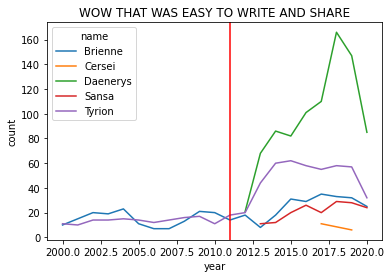

In [2]:
(baby_names
    .query('name in ["Sansa","Daenerys","Brienne","Cersei","Tyrion"] & \
     year >= 2000')
    .groupby(['name','year'])['count'].sum() # for each name-year, combine M and F counts
    .reset_index() # give us the column names back as they were (makes the plot call easy)
    .pipe((sns.lineplot, 'data'),hue='name',x='year',y='count')
)    
plt.axvline(2011, 0,160,color='red') # add a line for when the show debuted
plt.title("WOW THAT WAS EASY TO WRITE AND SHARE")
plt.show()

```{admonition} **WOW. That's nice code!**

Also: **Naming your baby after the "hero" Daenerys...**

...is a bad break. 
```

### Bonus analysis 


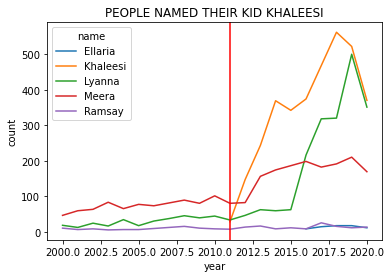

In [3]:
(baby_names
      .query('name in ["Khaleesi","Ramsay","Lyanna","Ellaria","Meera"] & \
         year >= 2000')
      .groupby(['name','year'])['count'].sum() # for each name-year, combine M and F counts
      .reset_index() # give use the column names back as they were (makes the plot call easy)
      .pipe((sns.lineplot, 'data'),hue='name',x='year',y='count')
)    
plt.axvline(2011, 0,160,color='red') # add a line for when the show debuted
plt.title("PEOPLE NAMED THEIR KID KHALEESI")
plt.show()

**BUT IT COULD BE WORSE**

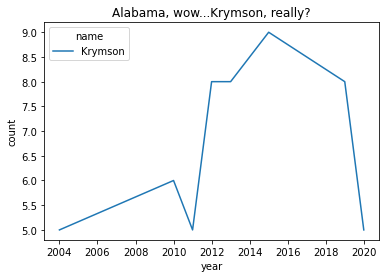

In [4]:
(baby_names
      .query('name in ["Krymson"] & year >= 1950')
      .groupby(['name','year'])['count'].sum() # for each name-year, combine M and F counts
      .reset_index() # give use the column names back as they were (makes the plot call easy)
      .pipe((sns.lineplot, 'data'),hue='name',x='year',y='count')
)    
plt.title("Alabama, wow...Krymson, really?")
plt.show()

### Summary, Tips, and Techniques

- Summary: 
    - In a method chain, you can use any valid method for the object that comes before  
    - Between two parentheses, you can break a long chain up, and add comments for readability
- You're writing a chain. Do you want to: 
    - Create a variable? Use `.assign(<newvariablename> = <some function>)`
    - Rename a variable? Use `.rename(columns={'<oldName>' : '<newName>'})`
    - Use a non-pandas function (e.g. plotting, like above) on a pandas object? Use `.pipe(<>)`
   
```{tip}   
See the [common tasks](02g_commontasks) page for tricks you can use within chains (pipe, csnap, lambda functions)!

See the [common functions](02c_commonFcns) page. Any method there that can be applied to a dataframe can be used within a chain.
```
